# Setup

In [1]:
import os
import time
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype = float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:]/n

def trim_predictions(preds,i):
    preds1=preds
    preds1[np.where(preds[:,1]>=20)]=20
    preds1[np.where(preds1[:,1]<0)]=0
    return preds1

In [3]:
#this cell from kaggle user coco bird
#https://www.kaggle.com/cocobird/previous-month-benchmark

def parse_date(df):
    _df = df.copy()
    _df["date"] = pd.to_datetime(_df.date, format="%d.%m.%Y")
    return _df

def day_month_year(df):
    _df = df.copy()
    _df["day"] = _df.date.apply(lambda x: x.day)
    _df["month"] = _df.date.apply(lambda x: x.month)
    _df["year"] = _df.date.apply(lambda x: x.year)
    return _df

# Transformers
parse_date_transformer = FunctionTransformer(parse_date, validate=False)
day_month_year_transformer = FunctionTransformer(day_month_year, validate=False)

# Pipelines
date_pipeline = make_pipeline(parse_date_transformer, day_month_year_transformer)

# Main Pipeline
preprocessing_pipeline = make_pipeline(date_pipeline)

# Preprocessing

In [4]:
#import data
# path = "C:/users/pythontensorflow/downloads/" #<data path>
path = '/Users/ML/Dropbox/Research/Machine Learning/Kaggle Predict Future Sales/'

sales = pd.read_csv(path + "sales_train.csv")
test_df = pd.read_csv(path + "test.csv")
items = pd.read_csv(path+"items.csv")

e = len(test_df)

In [5]:
#sort shops and omit those which are no longer open

sales_sorted = sales.sort_values("shop_id")

still_open = np.zeros(60)
for i in range(60):
    a = sales_sorted.loc[sales_sorted["shop_id"]==i]
    b= preprocessing_pipeline.transform(a)
    still_open[i] = max(b["year"])

for i in range(len(still_open)):
    if still_open[i] < 2015:
        sales_sorted = sales_sorted[sales_sorted.shop_id != i]
        
        
#parse dates
sales_sorted_dates = preprocessing_pipeline.transform(sales_sorted)

# Shop 2

To test the efficacy of different models, we use the data for shop 2 as a small test set.

##  Total Sales

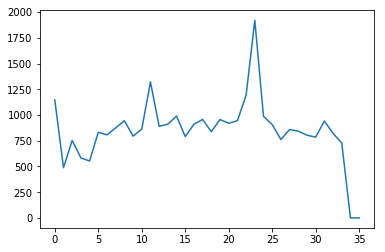

In [6]:
sales_tot = np.zeros([3,12])
q=0
for i in [2013,2014,2015]:
    for j in range(1,13):
        sales_tot[q,j-1] = sales_sorted_dates[ (sales_sorted_dates.shop_id == 2) & (sales_sorted_dates.month == j) & (sales_sorted_dates.year == i) ].item_cnt_day.sum()
    q = q + 1
    
sales_by_month = np.hstack(sales_tot)
plt.plot(sales_by_month)
plt.show()

## Total Sales by Item

In [28]:
shop_2 = sales_sorted_dates[sales_sorted_dates.shop_id == 2]

shop_2_unique = shop_2['item_id'].unique()

K = len(shop_2_unique)

item_sales_by_month = np.zeros([K,35])

r=0
for k in shop_2_unique:
    
    sales_tot_by_item = np.zeros([3,12])

    q=0
    for i in [2013,2014,2015]:
        for j in range(1,13):
            sales_tot_by_item[q,j-1] = shop_2[(shop_2.item_id == k) & (shop_2.month == j) & (shop_2.year == i) ].item_cnt_day.sum()
        q=q+1
        
    a = np.hstack(sales_tot_by_item)
      
    
    item_sales_by_month[r,0] = int(k)
    item_sales_by_month[r,1:] = a[:-2]
    
    r = r + 1 

## Models

### Apply Moving Average Filter to Data

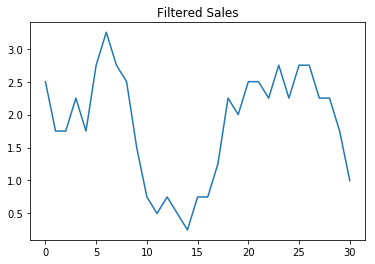

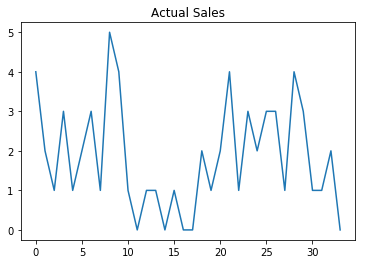

In [29]:
#select a single item to view sales data
itm = 0

#apply moving average filter
mov_av = moving_average(item_sales_by_month[itm,1:], n=4)
plt.title('Filtered Sales')
plt.plot(mov_av)

plt.show()

plt.figure()
plt.title('Actual Sales')
plt.plot(item_sales_by_month[itm,1:])

plt.show()

### Autoregressive Model

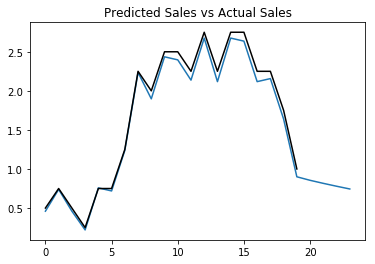

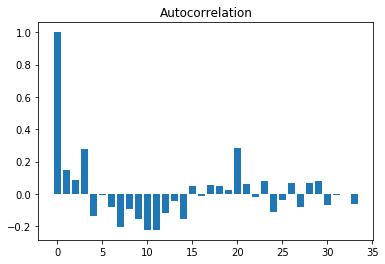

In [30]:
#AR applied to data filtered by moving average
acf = sm.tsa.acf(item_sales_by_month[itm,1:])
y_acf = np.arange(len(acf))

ar = sm.tsa.AR(mov_av).fit(2,trend='nc',disp=False)
# print(ar.params)
# print(ar.predict())

plt.figure()
plt.plot(np.abs(ar.predict(12,35)))
plt.title('Predicted Sales vs Actual Sales')
plt.plot(mov_av[11:], color='k')
plt.show()

plt.figure()
plt.title('Autocorrelation')
plt.bar(y_acf, acf)
plt.show()

### Decision Tree Models

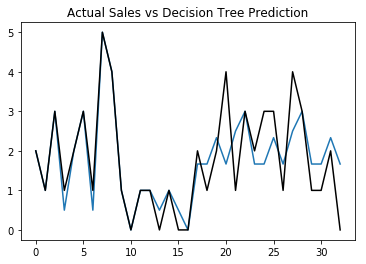

In [31]:
itm = 0

#incorporate calendar month as a feature
months = (np.arange(34) % 12)+1

feats = np.vstack((item_sales_by_month[itm,1:-1],months[1:]))

#select model type
model = GradientBoostingRegressor(n_estimators=150, max_depth =24)
# model = RandomForestRegressor(n_estimators=120, max_depth=6)
# model = BaggingRegressor(DecisionTreeRegressor(max_depth=12), n_estimators = 120)

model.fit(feats.reshape(len(months[1:]),2),item_sales_by_month[itm,2:])

pred = model.predict(feats.reshape(len(months[1:]),2))
# print(pred)
plt.figure()
plt.title('Actual Sales vs Decision Tree Prediction')
plt.plot(pred)
plt.plot(item_sales_by_month[itm,2:], color='k')
plt.show()

# All Shops

## Total Sales Data

In [43]:
output_path = 'C:\\Users\\PythonTensorflow\\Desktop\\Kaggle Output\\'
#output_path = <output_path>

all_monthly_sales = np.zeros([1,36])

for s in range(60):

    shop_s = sales_sorted_dates[sales_sorted_dates.shop_id == s]

    shop_s_unique = shop_s['item_id'].unique()

    K = len(shop_s_unique)

    store_item_sales_by_month = np.zeros([K,36])
    
    r=0
    
    for k in shop_s_unique:

        sales_tot_by_store_item = np.zeros([3,12])
        q=0
        
        for i in [2013,2014,2015]:
            for j in range(1,13):
                sales_tot_by_store_item[q,j-1] = shop_s[(shop_s.item_id == k) & (shop_s.month == j) & (shop_s.year == i) ].item_cnt_day.sum()
            q=q+1
            
        a = np.hstack(sales_tot_by_store_item)
      
        store_item_sales_by_month[r,0] = s
        store_item_sales_by_month[r,1] = k
        store_item_sales_by_month[r,2:] = a[:-2]
        
        r = r + 1
        
    all_monthly_sales = np.vstack((all_monthly_sales, array))
    
#     print(s)

all_monthly_sales = np.delete(all_monthly_sales, 0, 0)
np.savetxt(output_path + 'all_monthly_sales.csv', all_monthly_sales, delimiter = ',')

0
1


KeyboardInterrupt: 

In [45]:
#convert to pandas dataframe

#header data
M= np.arange(1,35).tolist()
for i in range(len(M)):
    M[i] = str(M[i])
H = ['shop','item']
H.extend(M)
len(H)

all_monthly_sales_df = pd.read_csv( output_path + 'all_monthly_sales.csv', header = None, delimiter = ',' )
all_monthly_sales_df.columns = H
#all_monthly_sales_df.drop('34', axis = 1, inplace = True)
all_monthly_sales_df.head()

,shop,item,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2.0,12134.0,4.0,2.0,1.0,3.0,1.0,2.0,3.0,1.0,...,2.0,3.0,3.0,1.0,4.0,3.0,1.0,1.0,2.0,0.0
1,2.0,5574.0,0.0,3.0,2.0,3.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,12172.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,11655.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0
4,2.0,11656.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Models

### AR Models

In [ ]:
#all_monthly_sales = pd.read_csv(output_path + 'all_monthly_sales')

months = (np.arange(34) % 12)+1

pred_min = 6

predictions = np.zeros([e,2])
q=0
for k in range(e): 
    
    #acf = sm.tsa.acf(store_item_sales_by_month[k,2:])
    #y_acf = np.arange(len(acf))
    
    ary = all_monthly_sales_df[(all_monthly_sales_df.shop == test_df['shop_id'][k]) & (all_monthly_sales_df.item == test_df['item_id'][k])][M]
    ary = ary.values
    
    if ary.shape[0]==0:
        predictions[q,1] = 0
        predictions[q,0] = q
        q = q + 1
        
    else:
        ar = sm.tsa.AR(ary[0,:]).fit(2,trend='nc',disp=False)
        
#         print(ar.params)
#         print(ar.predict())

        pred = ar.predict(pred_min,35)
        predictions[q,1] = pred[-1]
        predictions[q,0] = q
        q=q+1
        
#     plt.figure()
#     plt.title('Autocorrelation')
#     plt.bar(y_acf, acf)
#     plt.show()

### Decision Tree Models

In [109]:
#all_monthly_sales = pd.read_csv(output_path + 'all_monthly_sales')

months = (np.arange(34) % 12)+1

pred_min = 6

predictions = np.zeros([e,2])
q=0
for k in range(e):
    ary = all_monthly_sales_df[(all_monthly_sales_df.shop == test_df['shop_id'][k]) & (all_monthly_sales_df.item == test_df['item_id'][k])][M]
    ary = ary.values
    
    if ary.shape[0]==0:
        predictions[q,1] = 0
        predictions[q,0] = q
        q=q+1
    else:
        feats = np.vstack((ary[0,0:-1],months[1:])).reshape(len(months[1:]),2)
        tree_boost = GradientBoostingRegressor(n_estimators=120, max_depth =12)
        tree_boost.fit(feats, ary[0,1:])
        pred = tree_boost.predict(feats)
        
        predictions[q,1] = pred[-1]
        predictions[q,0] = q
        q=q+1

### Random Increase

In [129]:
#all_monthly_sales = pd.read_csv(output_path + 'all_monthly_sales')

months = (np.arange(34) % 12)+1

pred_min = 6
predictions = np.zeros([e,2])
q=0
for k in range(e): 
    ary = all_monthly_sales_df[(all_monthly_sales_df.shop == test_df['shop_id'][k]) & (all_monthly_sales_df.item == test_df['item_id'][k])][M]
    ary = ary.values
    
    if ary.shape[0]==0:
        predictions[q,1] = 0
        predictions[q,0] = q
        q = q + 1
        
    else:
        a = ary[0,22] - ary[0,21] #the amount of change from oct - nov the previous year
        b = ary[0,-1]
        r = np.random.uniform(0.5,1)
        predictions[q,1] = a+b*r #b + a * r???
        predictions[q,0] = q
        q=q+1
            

## Process Output

In [158]:
trial = 22

predictions_trimmed = trim_predictions(predictions)

# for k in range(e):
#     predictions_trimmed[k,0]=k
    
np.savetxt(output_path +'predictions%d.csv' %trial, predictions_trimmed, fmt = '%10.7f', delimiter = ',')